In [ ]:
!unzip "/content/Graz_dataset.zip"

Archive:  /content/Graz_dataset.zip
   creating: custom/
  inflating: custom/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/custom/
  inflating: __MACOSX/custom/._.DS_Store  
   creating: custom/images/
  inflating: custom/images/.DS_Store  
   creating: __MACOSX/custom/images/
  inflating: __MACOSX/custom/images/._.DS_Store  
   creating: custom/images/train/
  inflating: custom/images/train/BM_GRAZ_HE_0001_01_3.jpg  
   creating: __MACOSX/custom/images/train/
  inflating: __MACOSX/custom/images/train/._BM_GRAZ_HE_0001_01_3.jpg  
  inflating: custom/images/train/BM_GRAZ_HE_0001_01_2.jpg  
  inflating: __MACOSX/custom/images/train/._BM_GRAZ_HE_0001_01_2.jpg  
  inflating: custom/images/train/BM_GRAZ_HE_0004_01_8.jpg  
  inflating: __MACOSX/custom/images/train/._BM_GRAZ_HE_0004_01_8.jpg  
  inflating: custom/images/train/BM_GRAZ_HE_0001_01_0.jpg  
  inflating: __MACOSX/custom/images/train/._BM_GRAZ_HE_0001_01_0.jpg  
  inflating: custom/images/train/BM_GRAZ_HE_0001_01_1.

In [ ]:
images_path = "/content/custom/images/train"
labels_path = "/content/custom/labels/train"

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# create a density map

import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
import os
import matplotlib.pyplot as plt

def create_density_map(image_shape, yolo_annotations, sigma=2):
    """
    Create a density map for a given image and YOLO annotations.

    Args:
        image_shape (tuple): Shape of the image (height, width).
        yolo_annotations (list): List of YOLO annotations in the format:
                                 [[class_id, center_x, center_y, width, height], ...].
        sigma (int): Standard deviation for Gaussian smoothing.

    Returns:
        np.ndarray: Density map (same size as the input image).
    """
    height, width = image_shape
    density_map = np.zeros((height, width))

    # Convert YOLO annotations to pixel coordinates and add Gaussian peaks
    for annotation in yolo_annotations:
        _, center_x, center_y, _, _ = annotation
        center_x_pixel = int(center_x * width)
        center_y_pixel = int(center_y * height)

        # Ensure the coordinates are within bounds
        if 0 <= center_x_pixel < width and 0 <= center_y_pixel < height:
            density_map[center_y_pixel, center_x_pixel] = 1

    # Apply Gaussian filter to smooth the density map
    density_map = gaussian_filter(density_map, sigma=sigma)

    # Normalize the density map
    if np.max(density_map) > 0:
        density_map = density_map / np.max(density_map)

    return density_map



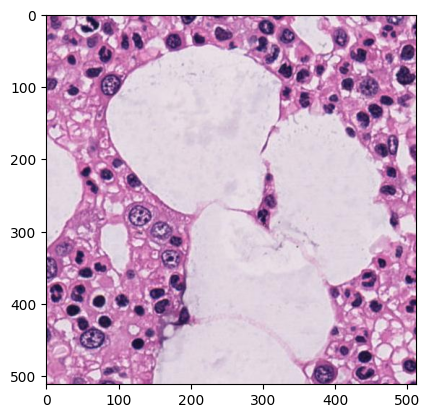

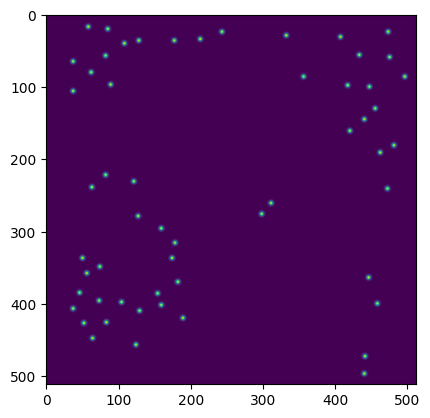

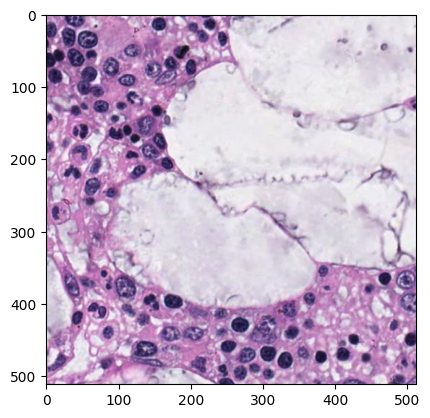

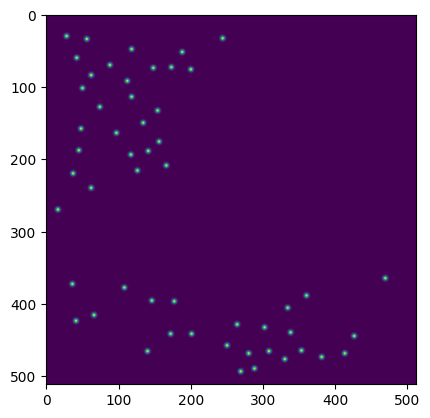

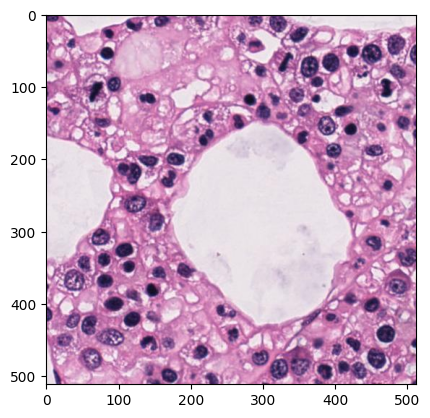

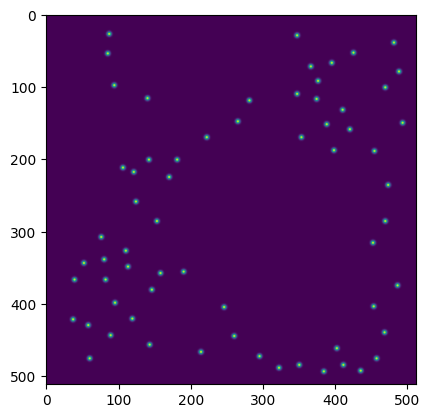

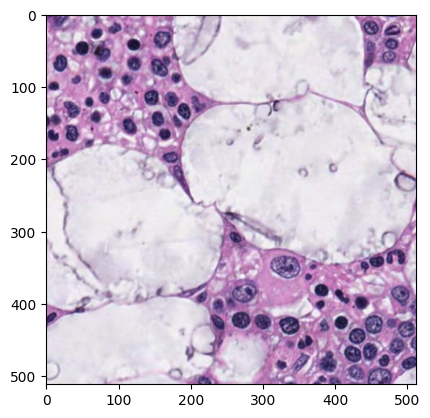

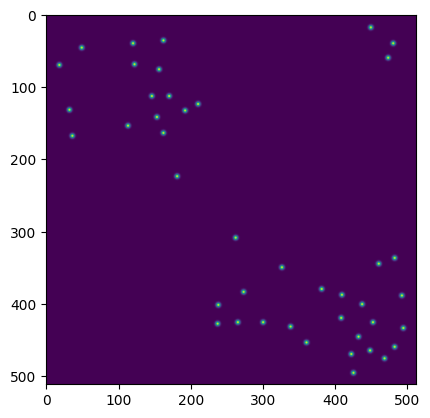

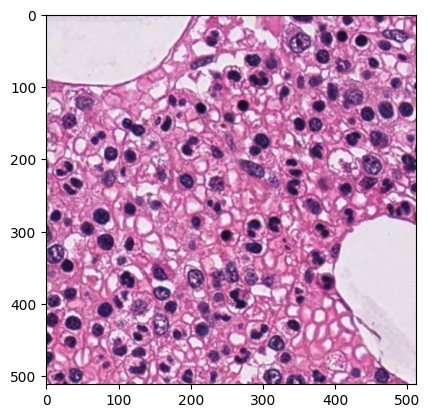

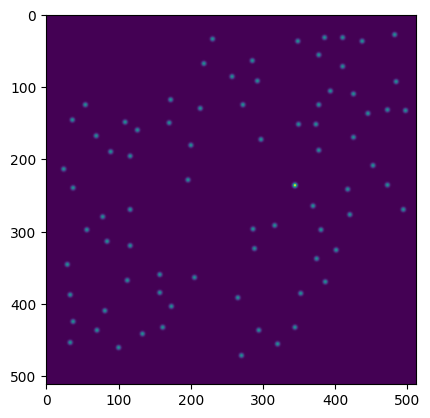

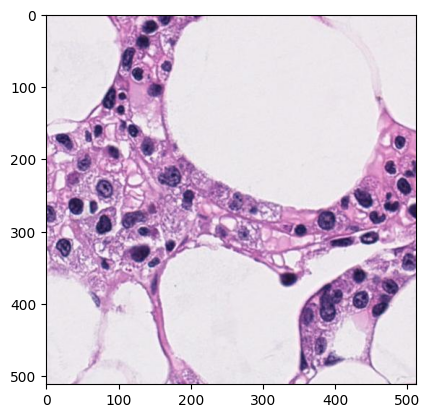

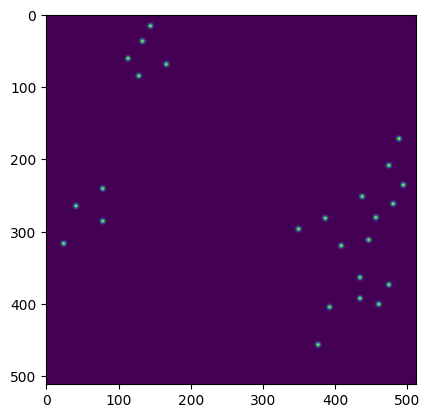

KeyboardInterrupt: 

In [ ]:
# Example usage
for img in os.listdir(images_path):
  path_extract = img.split('/')[0].split('.')
  path_yolo = labels_path+"/"+path_extract[0]+".txt"

  yolo_annotations = []

  for line in open(path_yolo, 'r'):
    yolo_annotations.append(list(map(float, line.split())))

  image_shape = (512, 512)

  density_map = create_density_map(image_shape, yolo_annotations, sigma=2)

  original_image = cv2.imread(images_path+"/"+img)
  img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  plt.imshow(density_map)
  plt.show()

In [ ]:
import os
from sklearn.model_selection import train_test_split

def split_dataset(image_dir, label_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    """
    Splits the dataset into train, validation, and test sets.

    Args:
        image_dir (str): Directory containing images.
        label_dir (str): Directory containing YOLO labels.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
        random_seed (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing file lists for train, val, and test sets.
    """
    # List all images and labels
    images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    labels = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)])

    # Ensure matching images and labels
    assert len(images) == len(labels), "Mismatch between images and labels!"
    for img, lbl in zip(images, labels):
        assert os.path.splitext(os.path.basename(img))[0] == os.path.splitext(os.path.basename(lbl))[0], \
            f"Mismatch: {img} and {lbl}!"

    # Split into train, val, and test
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        images, labels, test_size=(1 - train_ratio), random_state=random_seed
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed
    )

    return {
        "train": {"images": train_images, "labels": train_labels},
        "val": {"images": val_images, "labels": val_labels},
        "test": {"images": test_images, "labels": test_labels},
    }

# Example Usage
splits = split_dataset(images_path, labels_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print("Train size:", len(splits["train"]["images"]))
print("Validation size:", len(splits["val"]["images"]))
print("Test size:", len(splits["test"]["images"]))

Train size: 69
Validation size: 20
Test size: 10


In [ ]:
import os
import numpy as np
import tensorflow as tf
from scipy.ndimage import gaussian_filter
import cv2

class BiomedicalDataset:
    def __init__(self, image_size=(128, 128), sigma=2):
        """
        Initialize the dataset.

        Args:
            image_dir (str): Directory containing images.
            label_dir (str): Directory containing YOLO labels.
            image_size (tuple): Desired image size (height, width).
            sigma (int): Standard deviation for Gaussian smoothing.
        """
        self.image_dir = images_path
        self.label_dir = labels_path
        self.image_size = image_size
        self.sigma = sigma

        # Get sorted file lists to match images with labels
        self.image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path)])
        self.label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path)])

    def _load_image(self, file_path):
        """Load and preprocess an image."""
        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.image_size)
        image = image / 255.0  # Normalize to [0, 1]
        return image

    def _load_labels(self, file_path):
        """Load YOLO labels and convert them to density maps."""
        # Read YOLO labels
        labels = []
        with open(file_path, 'r') as f:
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                labels.append((x, y))  # We only need (center_x, center_y)

        # Create density map
        density_map = np.zeros(self.image_size)
        for x, y in labels:
            center_x = int(x * self.image_size[1])
            center_y = int(y * self.image_size[0])
            if 0 <= center_x < self.image_size[1] and 0 <= center_y < self.image_size[0]:
                density_map[center_y, center_x] = 1
        density_map = gaussian_filter(density_map, sigma=self.sigma)


        #plt.imshow(density_map)
        #plt.show()
        return density_map

    def __len__(self):
        """Return the number of samples."""
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            image = self._load_image(self.image_files[idx])
            density_map = self._load_labels(self.label_files[idx])
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")  # Print error details
            raise e  # Re-raise the exception to stop execution
        return image, density_map

    def to_tf_dataset(self, batch_size=8):
        """Convert the dataset to a tf.data.Dataset."""
        def generator():
            for i in range(len(self)):
                yield self[i]
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(*self.image_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=self.image_size, dtype=tf.float32),
            )
        )
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the FCRN model
def build_fcrn(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Decoder
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(1, (3, 3), strides=2, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, x)
    return model

In [ ]:
def build_fcrn_b(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Output heatmap
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
import torch

# Function to convert PyTorch DataLoader to TensorFlow Dataset
def create_tf_dataset_from_pytorch_loader(pytorch_loader):
    def generator():
        for images, labels in pytorch_loader:
            yield images.numpy(), labels.numpy()  # Convert PyTorch tensor to Numpy
    return tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 128, 128), dtype=tf.float32)
    ))

In [ ]:
from torch.utils.data import DataLoader

# Create datasets for each split
train_dataset = BiomedicalDataset(image_size=(128, 128), sigma=2)
val_dataset = BiomedicalDataset(image_size=(128, 128), sigma=2)
test_dataset = BiomedicalDataset(image_size=(128, 128), sigma=2)

# Create DataLoaders
train_loader = create_tf_dataset_from_pytorch_loader(DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0))
val_loader = create_tf_dataset_from_pytorch_loader(DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0))
test_loader = create_tf_dataset_from_pytorch_loader(DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0))

In [ ]:
model = build_fcrn_b()
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    patience=20,          # Number of epochs with no improvement after which training stops
    min_delta=0.0001,      # Minimum change in the monitored metric to qualify as an improvement
    verbose=1,           # Verbosity level (0 = silent, 1 = message on stop)
    restore_best_weights=True  # Restore weights of the best epoch
)

# Train the model with EarlyStopping
history = model.fit(
    train_loader,
    validation_data=val_loader,
    batch_size=1,
    epochs=100,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/100
     25/Unknown 7s 194ms/step - loss: 0.2824

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - loss: 0.2766 - val_loss: 0.0627
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.0639 - val_loss: 0.0627
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - loss: 0.0600 - val_loss: 0.0317
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - loss: 0.0287 - val_loss: 0.0248
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - loss: 0.0244 - val_loss: 0.0232
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - loss: 0.0231 - val_loss: 0.0237
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.0236 - val_loss: 0.0227
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - loss: 0.0232 - val_loss: 0.0225
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0235 - val_loss: 0.0222
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/st

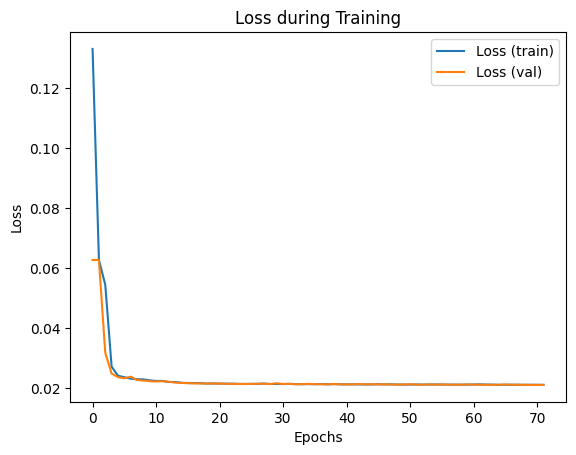

In [ ]:
import matplotlib.pyplot as plt

# Visualisation des pertes
def plot_loss(history):
    # Perte d'entraînement et de validation
    plt.plot(history.history['loss'], label='Loss (train)')
    plt.plot(history.history['val_loss'], label='Loss (val)')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the plot function
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


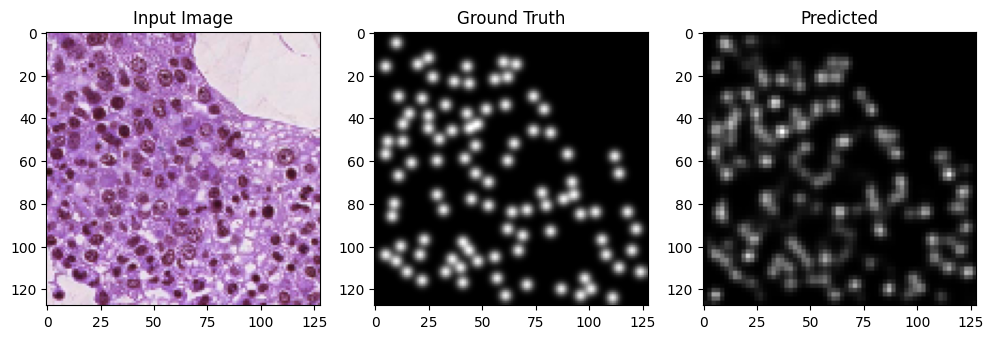

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


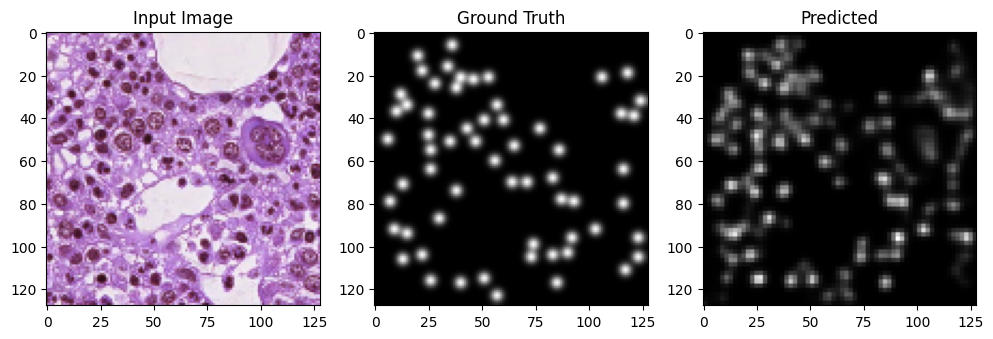

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


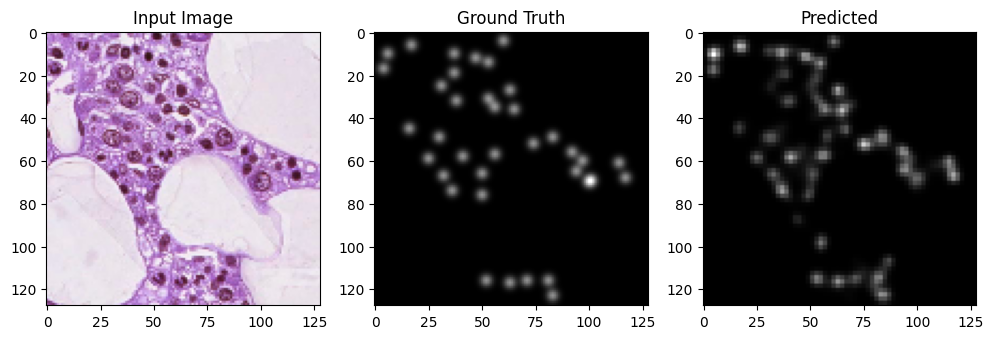

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


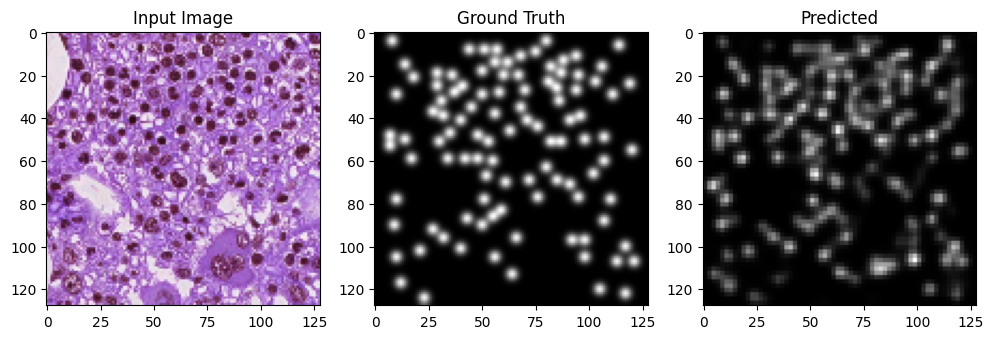

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


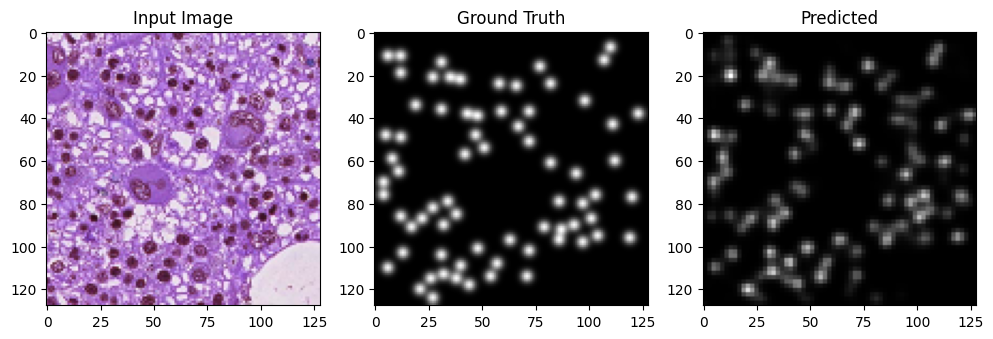

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to predict on test dataset and visualize results
def visualize_predictions(model, test_loader, num_images=5):
    # Model is automatically in evaluation mode when using predict
    for i, (images, labels) in enumerate(test_loader):
        if i >= num_images:
            break  # Only visualize the first 'num_images' examples

        images = images.numpy()  # Convert PyTorch tensors to Numpy arrays
        labels = labels.numpy()

        # Predict the output for the current batch using model.predict
        predictions = model.predict(images)  # Inference automatically in eval mode

        # Plot the images, ground truth, and predictions
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(images[0])  # First image in batch
        axes[0].set_title("Input Image")
        axes[1].imshow(labels[0], cmap='gray')  # Ground truth density map
        axes[1].set_title("Ground Truth")
        axes[2].imshow(predictions[0], cmap='gray')  # Predicted density map
        axes[2].set_title("Predicted")

        plt.show()

# Call the function to visualize predictions
visualize_predictions(model, test_loader, num_images=5)

In [ ]:
# Evaluate the model on the test dataset
test_loss = model.evaluate(test_loader)
print(f'Test Loss: {test_loss}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0219
Test Loss: 0.02110932767391205


Let's see if the model can determine where the blue spots are in the images before

[[0.7137255  0.69803923 0.69411767]
 [0.8        0.7921569  0.8       ]
 [0.78039217 0.7607843  0.7607843 ]
 [0.7882353  0.76862746 0.7647059 ]
 [0.75686276 0.74509805 0.7254902 ]
 [0.7294118  0.7176471  0.7019608 ]
 [0.7294118  0.74509805 0.7490196 ]
 [0.7372549  0.72156864 0.7176471 ]
 [0.7647059  0.7490196  0.75686276]
 [0.6784314  0.65882355 0.6666667 ]
 [0.76862746 0.76862746 0.7490196 ]
 [0.6431373  0.6392157  0.62352943]
 [0.67058825 0.67058825 0.6392157 ]
 [0.6392157  0.6156863  0.5882353 ]
 [0.54509807 0.5254902  0.50980395]
 [0.60784316 0.6        0.58431375]
 [0.68235296 0.6627451  0.6666667 ]
 [0.7372549  0.7372549  0.7529412 ]
 [0.6784314  0.6509804  0.6509804 ]
 [0.6392157  0.61960787 0.62352943]
 [0.75686276 0.7411765  0.7490196 ]
 [0.7882353  0.78039217 0.78039217]
 [0.7372549  0.72156864 0.7294118 ]
 [0.7372549  0.7254902  0.73333335]
 [0.77254903 0.76862746 0.7764706 ]
 [0.7764706  0.7882353  0.8039216 ]
 [0.80784315 0.8156863  0.8156863 ]
 [0.77254903 0.7647059  0.76

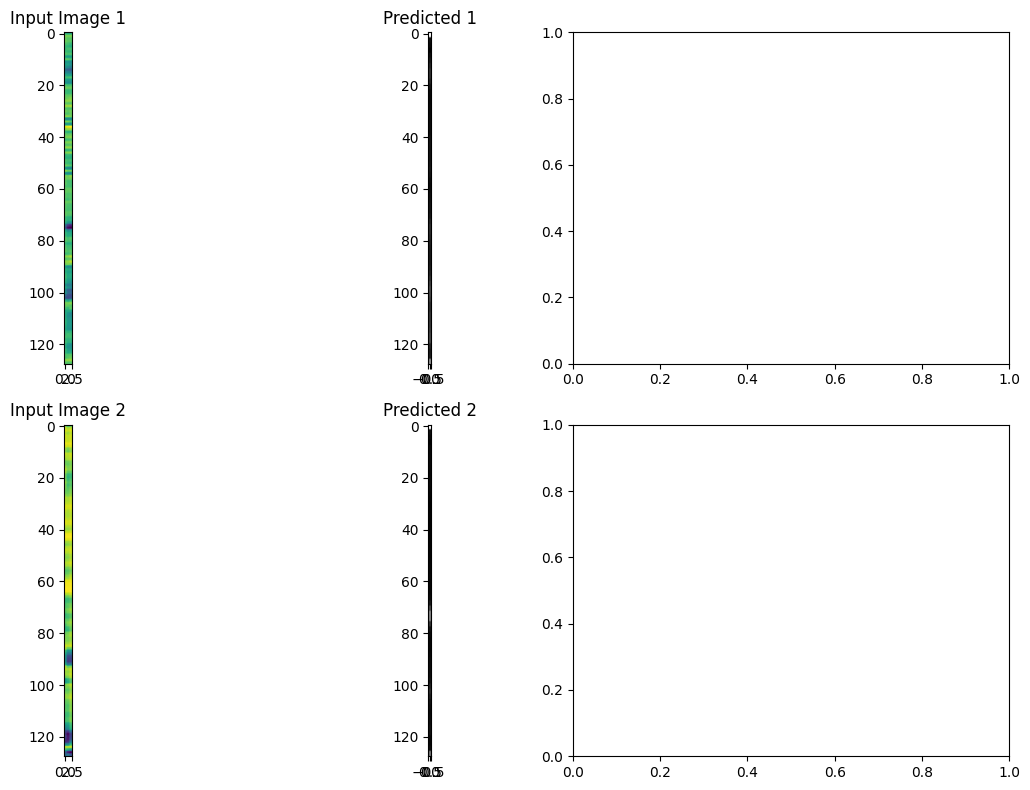

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return None  # or raise an exception if you prefer

    # Load the image using OpenCV (you can use PIL if you prefer)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image to match the model input size
    image = cv2.resize(image, target_size)

    # Normalize the image to [0, 1] (if required)
    image = image.astype(np.float32) / 255.0

    # Add batch dimension for model input (model expects a batch of images)
    #image = np.expand_dims(image, axis=0)

    #plt.imshow(image[0])
    #plt.show()

    return image

# Function to visualize predictions for two external images
def visualize_two_external_images(model, image_paths):
    # Load and preprocess the images
    images = np.array([load_and_preprocess_image(path) for path in image_paths])
    print(images[0][0])
    # Predict the output using the model
    predictions = model.predict(images)

    # Plot the input images and their predictions
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i in range(2):
        axes[i, 0].imshow(images[i][0])  # Input image (remove batch dimension)
        axes[i, 0].set_title(f"Input Image {i+1}")
        axes[i, 1].imshow(predictions[i][0], cmap='gray')  # Predicted density map
        axes[i, 1].set_title(f"Predicted {i+1}")

        # Optionally, you can add ground truth if available
        # axes[i, 2].imshow(ground_truth[i], cmap='gray')  # Ground truth (if available)
        # axes[i, 2].set_title(f"Ground Truth {i+1}")

    plt.tight_layout()
    plt.show()

# Example image paths (replace with your own paths)
image_paths = ["/content/101878272.png", "/content/hdAB.png", "/content/he.png"]

# Call the function to visualize predictions for two external images
visualize_two_external_images(model, image_paths)

[[0.85490197 0.78039217 0.8039216 ]
 [0.9529412  0.92156863 0.9372549 ]
 [0.9647059  0.9411765  0.9647059 ]
 [0.9411765  0.9137255  0.9411765 ]
 [0.95686275 0.9411765  0.95686275]
 [0.9529412  0.9411765  0.9529412 ]
 [0.9607843  0.94509804 0.9607843 ]
 [0.9843137  0.972549   0.98039216]
 [0.96862745 0.9529412  0.96862745]
 [0.9137255  0.88235295 0.9137255 ]
 [0.9019608  0.8666667  0.9019608 ]
 [0.9529412  0.9372549  0.9529412 ]
 [0.9372549  0.92941177 0.9490196 ]
 [0.9137255  0.9254902  0.9372549 ]
 [0.87058824 0.8745098  0.8901961 ]
 [0.8784314  0.85882354 0.88235295]
 [0.9098039  0.8784314  0.89411765]
 [0.9411765  0.8862745  0.8980392 ]
 [0.91764706 0.85490197 0.85882354]
 [0.8745098  0.8039216  0.8156863 ]
 [0.87058824 0.7882353  0.8156863 ]
 [0.8862745  0.80784315 0.8392157 ]
 [0.90588236 0.8352941  0.85490197]
 [0.8862745  0.8156863  0.84705883]
 [0.88235295 0.8352941  0.8666667 ]
 [0.87058824 0.8509804  0.88235295]
 [0.87058824 0.8666667  0.8901961 ]
 [0.9019608  0.8862745  0.90

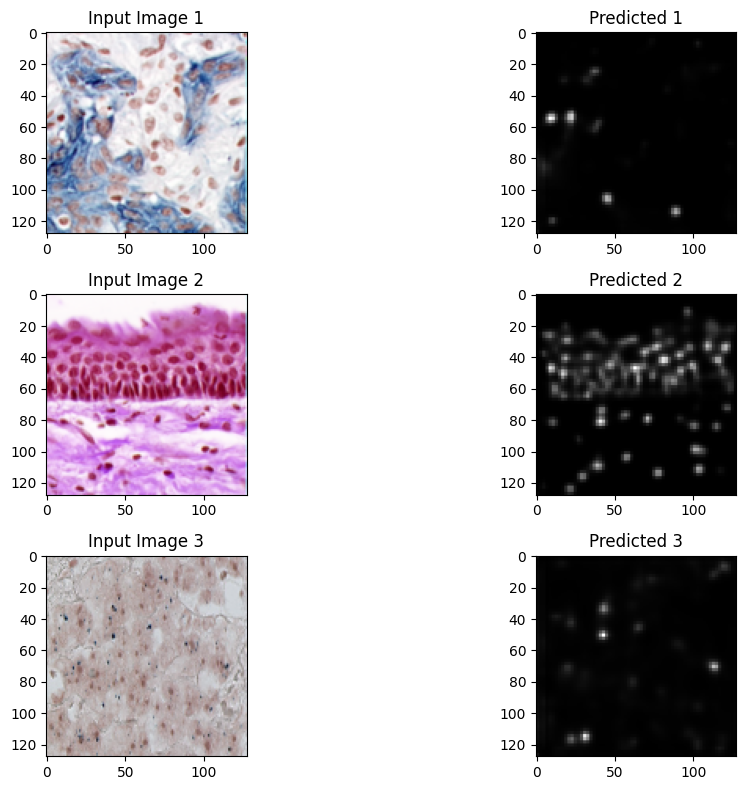

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Import the os module

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return None  # or raise an exception if you prefer

    # Load the image using OpenCV (you can use PIL if you prefer)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image to match the model input size
    image = cv2.resize(image, target_size)

    # Normalize the image to [0, 1] (if required)
    image = image.astype(np.float32) / 255.0

    # Add batch dimension for model input (model expects a batch of images)
    #image = np.expand_dims(image, axis=0)

    #plt.imshow(image[0])
    #plt.show()

    return image

# Function to visualize predictions for two external images
def visualize_two_external_images(model, image_paths):
    # Load and preprocess the images
    images = [load_and_preprocess_image(path) for path in image_paths]
    # Convert the list of images to a NumPy array with the correct shape
    images = np.stack(images, axis=0)  # Stack along the first axis (batch)

    print(images[0][0])
    # Predict the output using the model
    predictions = model.predict(images)

    # Plot the input images and their predictions
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(12, 8))  # Create subplots for all images
    #fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i in range(len(image_paths)):
        # If only one image, axes is not an array, so handle that case
        if len(image_paths) == 1:
            ax1, ax2 = axes[0], axes[1]  # Assuming 2 subplots for single image
        else:
            ax1, ax2 = axes[i, 0], axes[i, 1]

        ax1.imshow(images[i])  # Input image (remove batch dimension if needed)
        ax1.set_title(f"Input Image {i+1}")
        ax2.imshow(predictions[i], cmap='gray')  # Predicted density map
        ax2.set_title(f"Predicted {i+1}")

        # Optionally, you can add ground truth if available
        # axes[i, 2].imshow(ground_truth[i], cmap='gray')  # Ground truth (if available)
        # axes[i, 2].set_title(f"Ground Truth {i+1}")

    plt.tight_layout()
    plt.show()

# Example image paths (replace with your own paths)
image_paths = ["/content/hdAB.png", "/content/he.png", "/content/101878272.png"]

# Call the function to visualize predictions for two external images
visualize_two_external_images(model, image_paths)